In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import functools 
import datetime

import pmana.utils

In [2]:
TIME_DIR = "20251202"
TIME_RANGE = "20251202_20251203"

#### Parse CAEN DT5781 data

In [3]:
PATH_INPUT  = f"/Users/triozzi/Downloads/Run_fino_{TIME_DIR}_1500_LNL"
PATH_TARGET = f"../data/{TIME_DIR}/DataPadova_DT5781_{TIME_RANGE}"

pmana.utils.io.FormatDT5781Data(
    PATH_INPUT,  ###< raw Padova test-stand campaign
    PATH_TARGET  ###< target path for the restructured data
)

#### Look at one single measurement

There were 3 used channels in this measurement.
Skipping the first 5 rows.
Skipping the first 5 rows.
Skipping the first 5 rows.


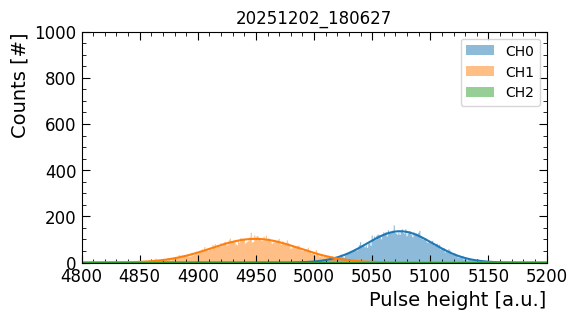

In [7]:
fig, ax = plt.subplots(figsize=(6,3))

MEASUREMENT = '20251202_180627'
# extract a measurement 
Data = pmana.utils.io.ExtractSingleMeasurement(
    f"../data/{TIME_DIR}/DataPadova_DT5781_{TIME_RANGE}/{MEASUREMENT}",
    CHANNEL_KEY = 'CH*', N_SKIP_LINES = 3, COL_NAMES = ['c0', 'c1', 'c2'], DELIMITER = ' '
)
print(f"There were {len(Data)} used channels in this measurement.")

CHs = [1, 2, 3]
for i, chname in enumerate(CHs):
    # plot channel data
    pmana.utils.plotting.PlotSingleChannel(
        Data[i],
        ax,
        channel = i,
        rebin = False,
        debug = False,
        DISPLAY_FIT = True, 
        SKIP_NROWS = 5, BINNAME = 'c0', COUNTNAME = 'c1'
    )

ax = pmana.utils.plotting.UpdateMatplotlibStyle(
    ax,
    "Pulse height [a.u.]",
    "Counts [#]"
)

ax.legend()
ax.set_title(f"{MEASUREMENT}")

#ax.set_yscale('log')

ax.set_xlim(4800, 5200)
# ax.set_xlim(1230, 1240)
ax.set_ylim(0, 1000)

plt.show()

There were 3 used channels in this measurement.
Skipping the first 5 rows.
Skipping the first 5 rows.
Skipping the first 5 rows.


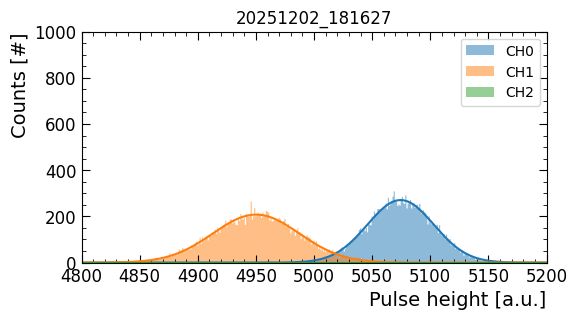

In [8]:
fig, ax = plt.subplots(figsize=(6,3))

MEASUREMENT = '20251202_181627'
# extract a measurement 
Data = pmana.utils.io.ExtractSingleMeasurement(
    f"../data/{TIME_DIR}/DataPadova_DT5781_{TIME_RANGE}/{MEASUREMENT}",
    CHANNEL_KEY = 'CH*', N_SKIP_LINES = 3, COL_NAMES = ['c0', 'c1', 'c2'], DELIMITER = ' '
)
print(f"There were {len(Data)} used channels in this measurement.")

CHs = [1, 2, 3]
for i, chname in enumerate(CHs):
    # plot channel data
    pmana.utils.plotting.PlotSingleChannel(
        Data[i],
        ax,
        channel = i,
        rebin = False,
        debug = False,
        DISPLAY_FIT = True, 
        SKIP_NROWS = 5, BINNAME = 'c0', COUNTNAME = 'c1'
    )

ax = pmana.utils.plotting.UpdateMatplotlibStyle(
    ax,
    "Pulse height [a.u.]",
    "Counts [#]"
)

ax.legend()
ax.set_title(f"{MEASUREMENT}")

#ax.set_yscale('log')

ax.set_xlim(4800, 5200)
# ax.set_xlim(1230, 1240)
ax.set_ylim(0, 1000)

plt.show()

#### Analyze a campaign

In [9]:
PATH_CAMPAIGN = f"../data/{TIME_DIR}/DataPadova_DT5781_{TIME_RANGE}"
# PATH_TEMPERATURES = f"../data/{TIME_DIR}/PM_Temperature_{TIME_RANGE}.txt"

In [4]:
# get temperature mapping
# Temperatures = pmana.utils.io.ExtractTemperatureMonitoring(
#     PATH_TEMPERATURES
# )

In [10]:
# analyze campaign
Output = pmana.utils.anatestdata.Iterate(
    PATH_CAMPAIGN,                                          ###< path to restructured data
    # pmana.utils.anatestdata.AnalyzeMeasurement, 
    functools.partial(pmana.utils.anatestdata.GaussianFitToChannel, 
        IS_DT5781=True, rebin=False, debug=False,
        SKIP_NROWS = 5, BINNAME = 'c0', COUNTNAME = 'c1'),  ###< analyzing module, changing some options 
    None,                                                   ###< time mapping not available explicitly
    DIR_KEY = '2*'                                          ###< how to look for measurement directories    
)

# convert top DataFrame
Output = pandas.DataFrame(Output)

# re-format the dataframe
Output.columns = ["Peak_CH1", "Err_Peak_CH1", "Width_CH1", "Err_Width_CH1",
                  "Peak_CH2", "Err_Peak_CH2", "Width_CH2", "Err_Width_CH2", 
                  "Peak_CH3", "Err_Peak_CH3", "Width_CH3", "Err_Width_CH3", 
                #   "Peak_CH4", "Err_Peak_CH4", "Width_CH4", "Err_Width_CH4", 
                #   "Peak_CH5", "Err_Peak_CH5", "Width_CH5", "Err_Width_CH5", 
                #   "Peak_CH6", "Err_Peak_CH6", "Width_CH6", "Err_Width_CH6", 
                #   "Peak_CH7", "Err_Peak_CH7", "Width_CH7", "Err_Width_CH7",
                #   "Peak_CH8", "Err_Peak_CH8", "Width_CH8", "Err_Width_CH8",  
                  "Date", "Number"]

# sort by date
Output.sort_values(
    by = 'Date', 
    inplace = True,
    ignore_index = True
)

In [11]:
# temporarily drop NaNs... ideally, actually resolve the issue
# by retaining time even when not all channels are available
Output = Output.dropna(
  how = 'any',
  subset = ['Date']
)

# temporarily drop zero values from bad fits... ideally,
# you should fix the failing fits rather than skipping them
Output = Output[Output.Peak_CH3 > 0]

# properly handle data types
# not always needed
Vars = Output.columns[:-2]
Output[Vars] = Output[Vars].astype(float)

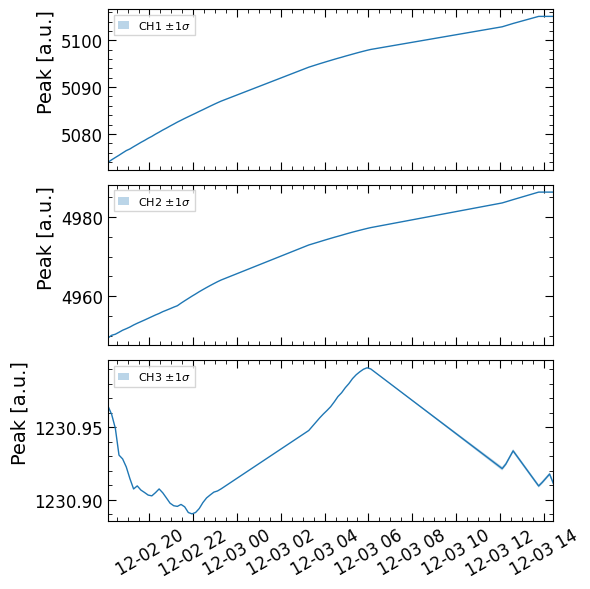

In [13]:
fig, ax = plt.subplots(figsize=(6, 2.*3), nrows=3, layout='tight')

# CH1
ax[0].plot(Output.Date, Output.Peak_CH1, lw=1)
ax[0].fill_between(Output.Date, Output.Peak_CH1-Output.Err_Peak_CH1,  Output.Peak_CH1+Output.Err_Peak_CH1, alpha=0.3, label='CH1 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0], None, 'Peak [a.u.]')
ax[0].set_xticklabels([])

# CH2
ax[1].plot(Output.Date, Output.Peak_CH2, lw=1)
ax[1].fill_between(Output.Date, Output.Peak_CH2-Output.Err_Peak_CH2,  Output.Peak_CH2+Output.Err_Peak_CH2, alpha=0.3, label='CH2 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1], None, 'Peak [a.u.]')
ax[1].set_xticklabels([])

# CH3
ax[2].plot(Output.Date, Output.Peak_CH3.astype(float), lw=1)
ax[2].fill_between(Output.Date, Output.Peak_CH3-Output.Err_Peak_CH3,  Output.Peak_CH3+Output.Err_Peak_CH3, alpha=0.3, label='CH3 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[2], None, 'Peak [a.u.]')
ax[2].ticklabel_format(useOffset=False, axis='y')
# ax[2].set_xticklabels([])


for a in ax:
    # gfx
    a.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='upper left')
    a.tick_params(axis='x', labelrotation=30)
    a.set_xlim(Output['Date'].iloc[0], Output['Date'].iloc[-1])

    '''
    # plot temperatures
    a2 = a.twinx()
    a2.fill_between(Temperatures.Date, y1=Temperatures.T1, y2=Temperatures.T2, fc='red', alpha=0.4, label='Temperature', zorder=-3)
    pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'T [°C]')
    a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='lower left')
    '''
plt.show()

fig.savefig(f"../plots/DT5781_{TIME_RANGE}.png", dpi=300, bbox_inches='tight')

#### Compare with oscilloscope-based setup

In [51]:
CH1 = pandas.read_csv(f'../out/{TIME_RANGE}_Complete_CH1.txt', delimiter=' ')
CH1['Date'] = pandas.to_datetime(CH1['Date'], format="%Y-%m-%d %H:%M:%S")

CH2 = pandas.read_csv(f'../out/{TIME_RANGE}_Complete_CH2.txt', delimiter=' ')
CH2['Date'] = pandas.to_datetime(CH2['Date'], format="%Y-%m-%d %H:%M:%S")

CH3 = pandas.read_csv(f'../out/{TIME_RANGE}_Complete_CH3.txt', delimiter=' ')
CH3['Date'] = pandas.to_datetime(CH3['Date'], format="%Y-%m-%d %H:%M:%S")

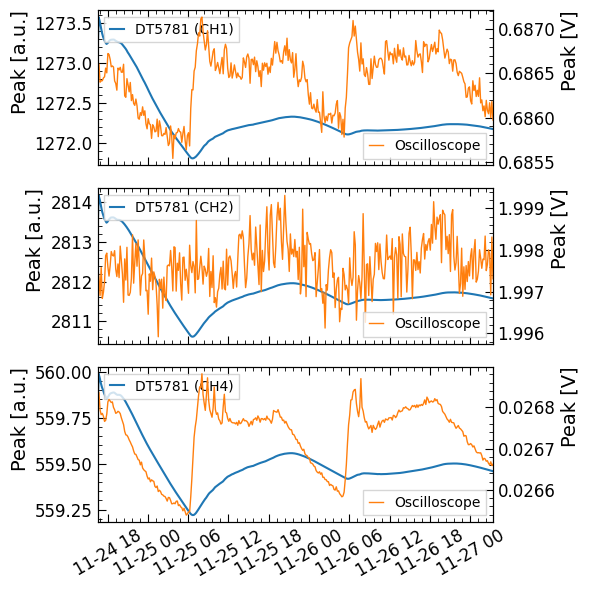

In [65]:
fig, ax = plt.subplots(figsize=(6, 2.*3), nrows=3, layout='tight')

# CH1
ax[0].plot(Output.Date, Output.Peak_CH1, lw=1.5, label='DT5781 (CH1)')
ax[0].fill_between(Output.Date, Output.Peak_CH1-Output.Err_Peak_CH1,  Output.Peak_CH1+Output.Err_Peak_CH1, alpha=0.3)
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0], None, 'Peak [a.u.]')
ax[0].set_xticklabels([])

# CH2
ax[1].plot(Output.Date, Output.Peak_CH2, lw=1.5, label='DT5781 (CH2)')
ax[1].fill_between(Output.Date, Output.Peak_CH2-Output.Err_Peak_CH2,  Output.Peak_CH2+Output.Err_Peak_CH2, alpha=0.3)
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1], None, 'Peak [a.u.]')
ax[1].set_xticklabels([])

# CH3
ax[2].plot(Output.Date, Output.Peak_CH3.astype(float), lw=1.5, label='DT5781 (CH4)')
ax[2].fill_between(Output.Date, Output.Peak_CH3-Output.Err_Peak_CH3,  Output.Peak_CH3+Output.Err_Peak_CH3, alpha=0.3)
pmana.utils.plotting.UpdateMatplotlibStyle(ax[2], None, 'Peak [a.u.]')
# ax[2].set_xticklabels([])


for a, ch in zip(ax, [CH1, CH2, CH3]):
    # gfx
    a.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='upper left')
    a.tick_params(axis='x', labelrotation=30)
    a.set_xlim(Output['Date'].iloc[0], Output['Date'].iloc[-1])

    # plot temperatures
    a2 = a.twinx()
    a2.plot(ch.Date, ch.Peak, lw=1., c='C1', label='Oscilloscope')
    # a2.fill_between(Temperatures.Date, y1=Temperatures.T1, y2=Temperatures.T2, fc='red', alpha=0.4, label='Temperature', zorder=-3)
    pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Peak [V]')
    a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='lower right')

plt.show()
fig.savefig(f"../plots/DT5781_Oscilloscope_{TIME_RANGE}.png", dpi=300, bbox_inches='tight')